In [1]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

2024-07-16 16:44:32.521164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cpu



In [13]:
modelname = 'AlexNet'
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the paths for the datasets
base_folder = "/Users/ishaanbabbar/Desktop/GT Summer 2024/DSAN 6500/Project/wsirois"
train_folder = os.path.join(base_folder, "train")
test_folder = os.path.join(base_folder, "test")
validation_folder = os.path.join(base_folder, "validation")

In [15]:
# Create datasets
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)
validation_dataset = ImageFolder(root=validation_folder, transform=transform)

batchsize = 32
numworkers = 4
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train_one_epoch(model, data_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    top5_correct = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

         # Add top 5 accuracy
        _, top5_predicted = outputs.topk(5,1, True, True)
        top5_correct += top5_predicted.eq(labels.view(-1, 1).expand_as(top5_predicted)).sum().item()
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    top5_accuracy = top5_correct / total_predictions
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, top5_accuracy, precision, recall, f1

In [46]:
def evaluate(model, data_loader, criterion, device, epoch, num_epochs, phase='Validation'):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    top5_correct = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch and phase (Validation or Testing)
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - {phase}"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

        # Add top 5 accuracy
        _, top5_predicted = outputs.topk(5,1, True, True)
        top5_correct += top5_predicted.eq(labels.view(-1, 1).expand_as(top5_predicted)).sum().item()
        
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
            
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    top5_accuracy = top5_correct / total_predictions
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, top5_accuracy, precision, recall, f1

In [47]:
output_folder = "/Users/ishaanbabbar/Desktop/GT Summer 2024/DSAN 6500/Project/wsirois/output"

# Load and modify the pretrained AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 200)
model.to(device)

#num_classes = len(train_dataset.classes)
#model.classifier = nn.Sequential(
#    nn.Dropout(p=0.2, inplace=False),
#    nn.Linear(model.classifier[1].in_features, num_classes)
#)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler - define your warmup_cosine_annealing scheduler here

num_epochs = 10
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))

writer = SummaryWriter('../runs/AlexNet_experiment')

# Initialize DataFrame to store metrics
columns = [
    'Epoch', 'Training Loss', 'Validation Loss', 'Test Loss',
    'Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
    'Training Precision', 'Training Recall', 'Training F1-Score',
    'Validation Precision', 'Validation Recall', 'Validation F1-Score',
    'Test Precision', 'Test Recall', 'Test F1-Score',
    'Epoch Duration', 'Training Top-5 Accuracy', 'Validation Top-5 Accuracy', 'Test Top-5 Accuracy'
]
df = pd.DataFrame(columns=columns)

best_val_accuracy = 0  # Initialize best validation accuracy for checkpointing

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss, train_accuracy, train_prec, train_rec, train_f1, train_top5_acc = train_one_epoch(
    model, train_loader, criterion, optimizer, device, epoch, num_epochs)

    val_loss, val_accuracy, val_prec, val_rec, val_f1, val_top5_acc = evaluate(
    model, validation_loader, criterion, device, epoch, num_epochs, phase='Validation')

    test_loss, test_accuracy, test_prec, test_rec, test_f1, test_top5_acc = evaluate(
    model, test_loader, criterion, device, epoch, num_epochs, phase='Testing')

    epoch_duration = time.time() - start_time
    scheduler.step()

    # Log to TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss, 'Test': test_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Validation': val_accuracy, 'Test': test_accuracy}, epoch)
    writer.add_scalars('Precision', {'Train': train_prec, 'Validation': val_prec, 'Test': test_prec}, epoch)
    writer.add_scalars('Recall', {'Train': train_rec, 'Validation': val_rec, 'Test': test_rec}, epoch)
    writer.add_scalars('F1-Score', {'Train': train_f1, 'Validation': val_f1, 'Test': test_f1}, epoch)
    writer.add_scalars('Top-5 Accuracy', {'Train': train_top5_acc, 'Validation': val_top5_acc, 'Test': test_top5_acc}, epoch)

    # Update DataFrame
    new_row = {
        'Epoch': epoch + 1, 'Training Loss': train_loss, 'Validation Loss': val_loss, 'Test Loss': test_loss,
        'Training Accuracy': train_accuracy, 'Validation Accuracy': val_accuracy, 'Test Accuracy': test_accuracy,
        'Training Precision': train_prec, 'Training Recall': train_rec, 'Training F1-Score': train_f1,
        'Validation Precision': val_prec, 'Validation Recall': val_rec, 'Validation F1-Score': val_f1,
        'Test Precision': test_prec, 'Test Recall': test_rec, 'Test F1-Score': test_f1,
        'Epoch Duration': epoch_duration, 'Training Top-5 Accuracy': train_top5_acc, 'Validation Top-5 Accuracy': val_top5_acc,
        'Test Top-5 Accuracy': test_top5_acc
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Checkpointing
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(output_folder, f'AlexNet_best.pth'))

writer.close()

# Save the DataFrame to a CSV file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"AlexNet_training_results_{timestamp}.csv"
df.to_csv(os.path.join(output_folder, csv_filename), index=False)

Epoch 1/10 - Testing: 100%|███████████████████████| 5/5 [00:32<00:00,  6.59s/it]
/var/folders/yp/ms18mh5d3gl1jr8k6cjqw0h40000gn/T/ipykernel_27055/3350734998.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
Epoch 10/10 - Testing: 100%|██████████████████████| 5/5 [00:34<00:00,  6.84s/it]


Best top 1 Accuracy: 0.9 (90%) and Best Top 5 accuracy percentage: 0.874 (87.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


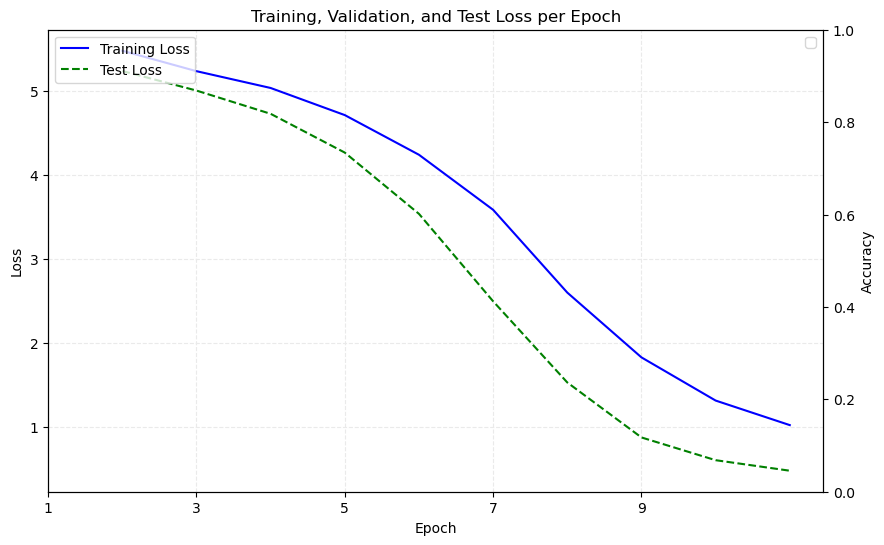

In [48]:
import matplotlib.pyplot as plt

# Ensure 'Test Loss' and 'Validation Loss' are present in your DataFrame
plt.figure(figsize=(10, 6))

# Plot training, test, and validation loss
plt.plot(df['Epoch'], df['Training Loss'], linestyle='-', color='blue', label='Training Loss')
plt.plot(df['Epoch'], df['Test Loss'], linestyle='--', color='green', label='Test Loss')

# Optionally, plot validation and test accuracy if you wish to visualize accuracy on a secondary axis
plt.title('Training, Validation, and Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1, 2))  # Adjust this based on your actual number of epochs
plt.grid(True, which='both', axis='both', linestyle='--', color="#eaeaea")
plt.legend(loc='upper left')

# Create a secondary y-axis to plot accuracy if needed
sec_axis = plt.twinx()
sec_axis.set_ylabel('Accuracy')
sec_axis.legend(loc='upper right')

plt.savefig(os.path.join(output_folder, f"training_validation_test_loss_plot_{modelname}_{timestamp}.png"), dpi=300)  # Save the plot as a PNG file
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def get_all_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.view(-1).tolist())
            all_labels.extend(labels.view(-1).tolist())
    return all_preds, all_labels

# Get predictions and true labels for both datasets
train_preds, train_labels = get_all_predictions(train_loader, model, device)
val_preds, val_labels = get_all_predictions(validation_loader, model, device)
test_preds, test_labels = get_all_predictions(test_loader, model, device)

# Compute confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)
test_cm = confusion_matrix(test_labels, test_preds)

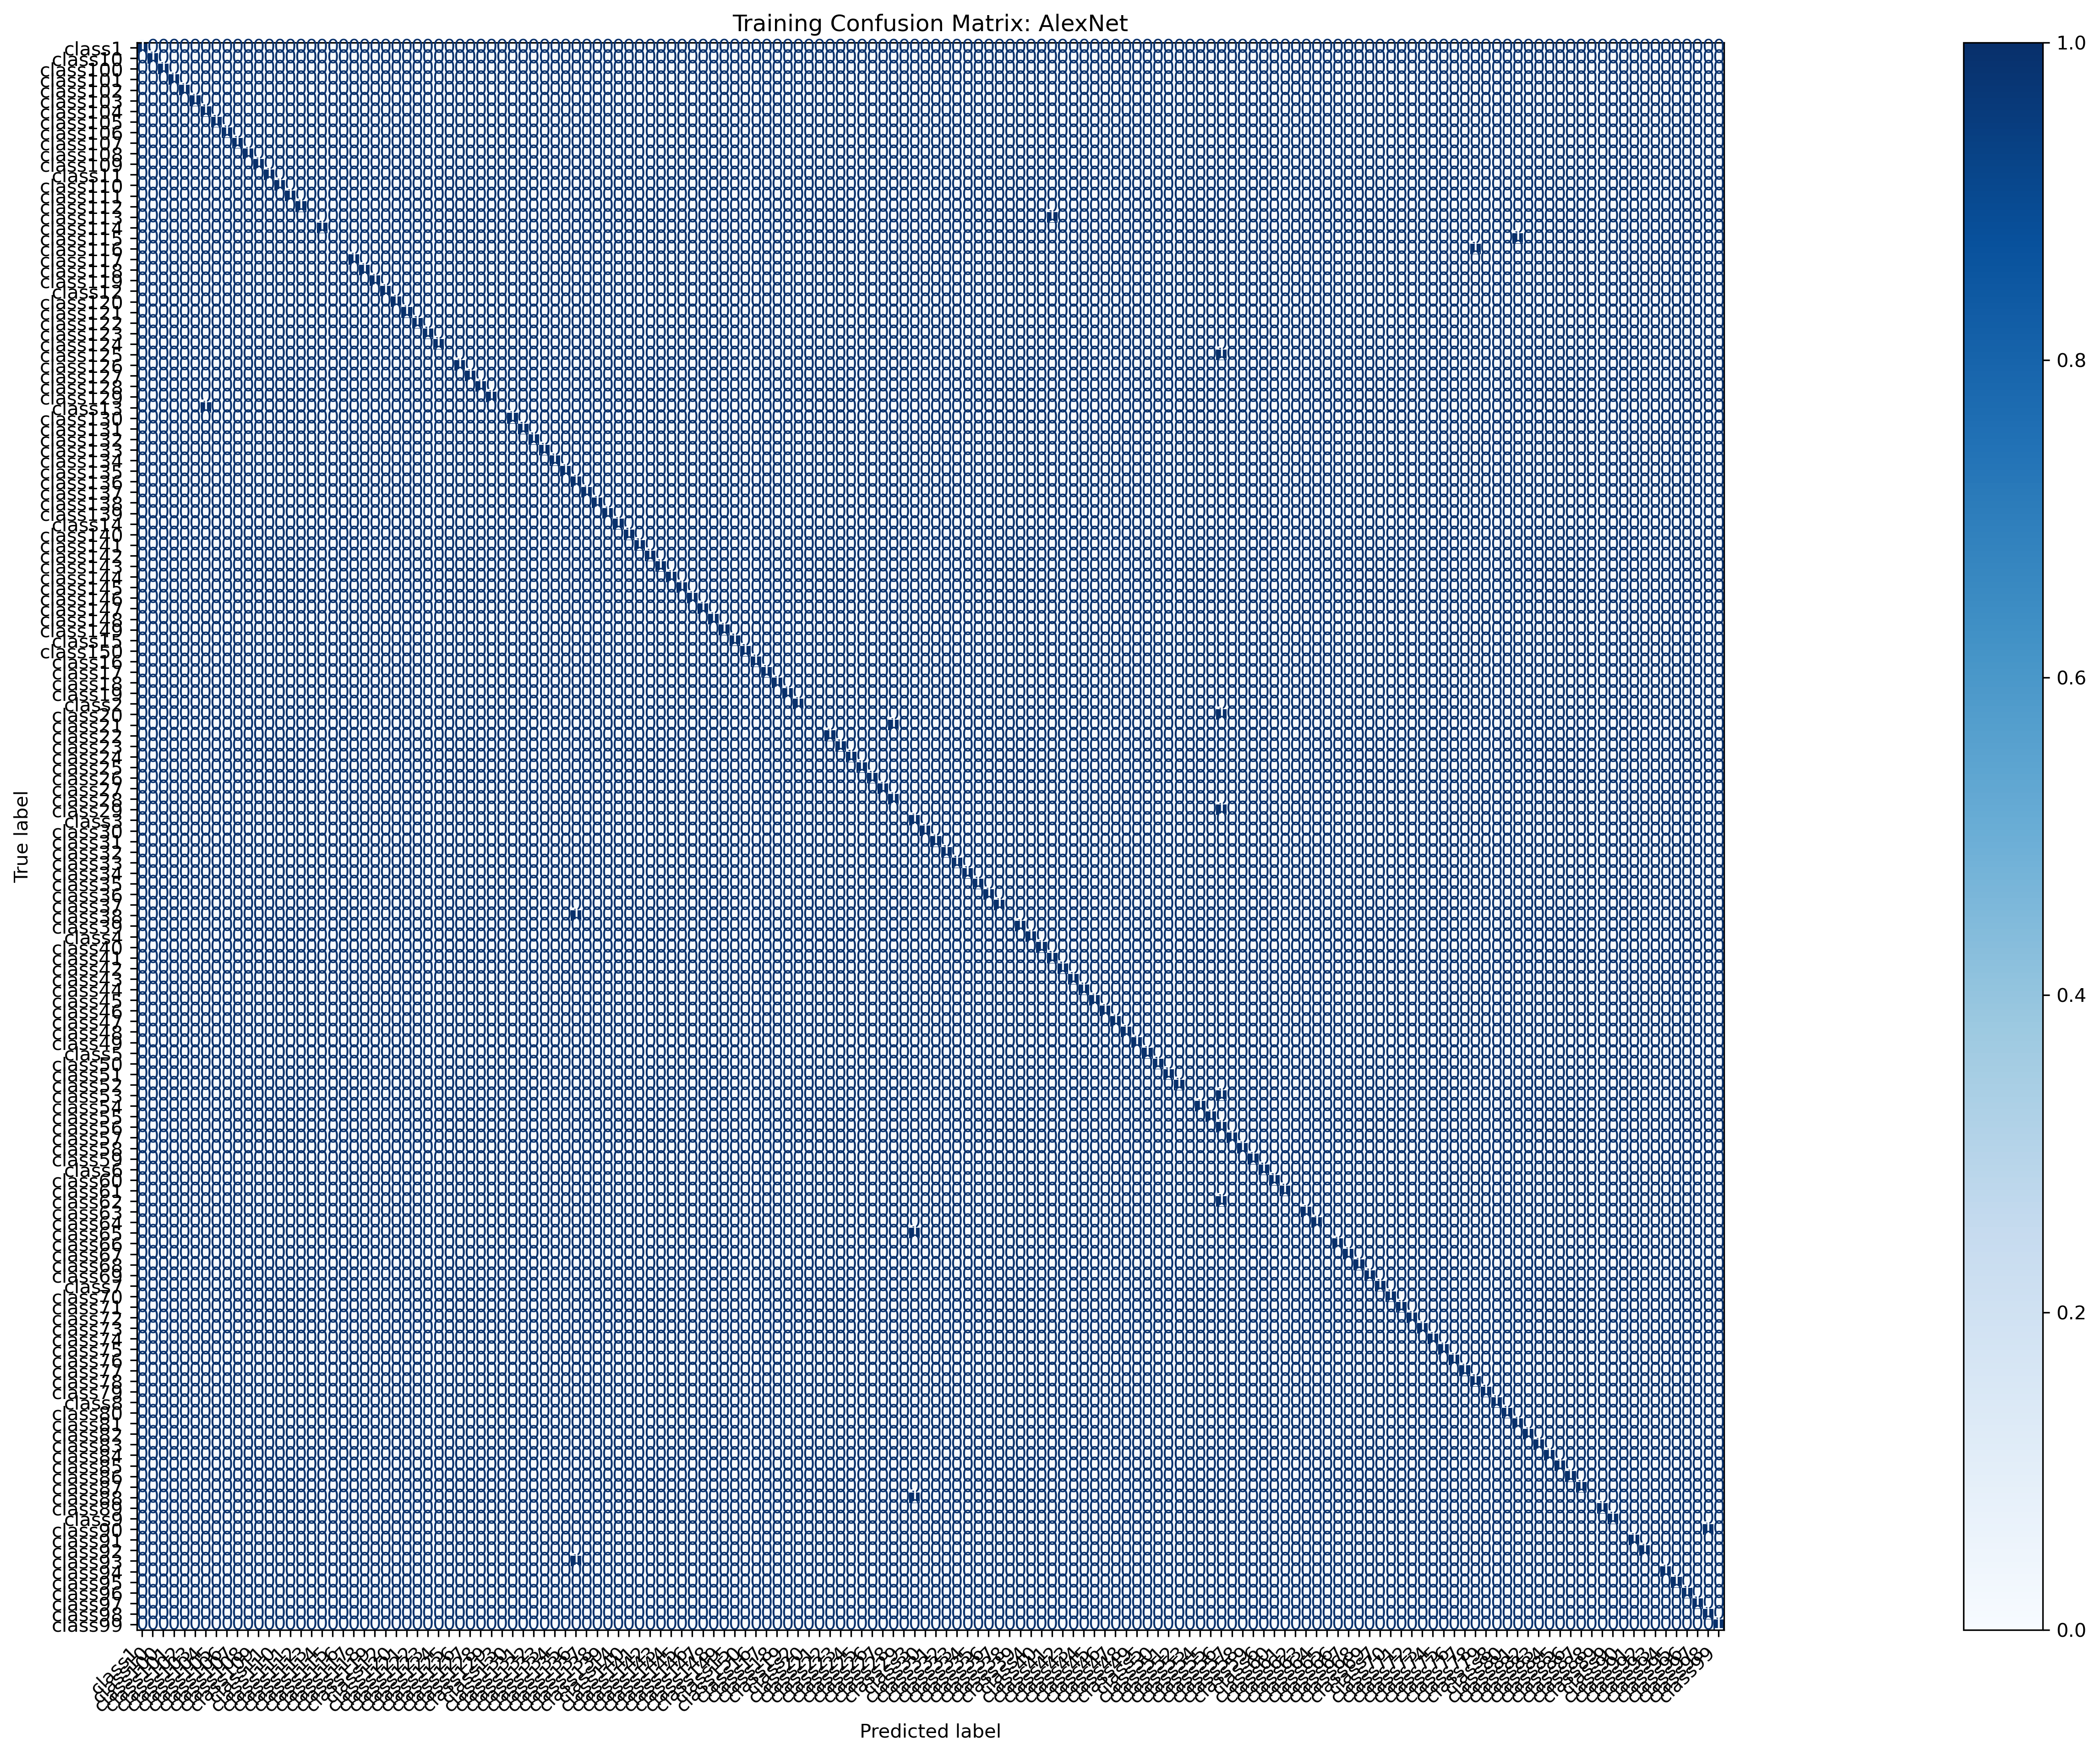

In [33]:
# Plot confusion matrices

fig, ax = plt.subplots(figsize=(45, 15), dpi=300)

ConfusionMatrixDisplay(train_cm, display_labels=train_dataset.classes).plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title('Training Confusion Matrix: AlexNet')
ax.set_xticklabels(rotation=45, labels=train_dataset.classes, ha= 'right')


plt.show()

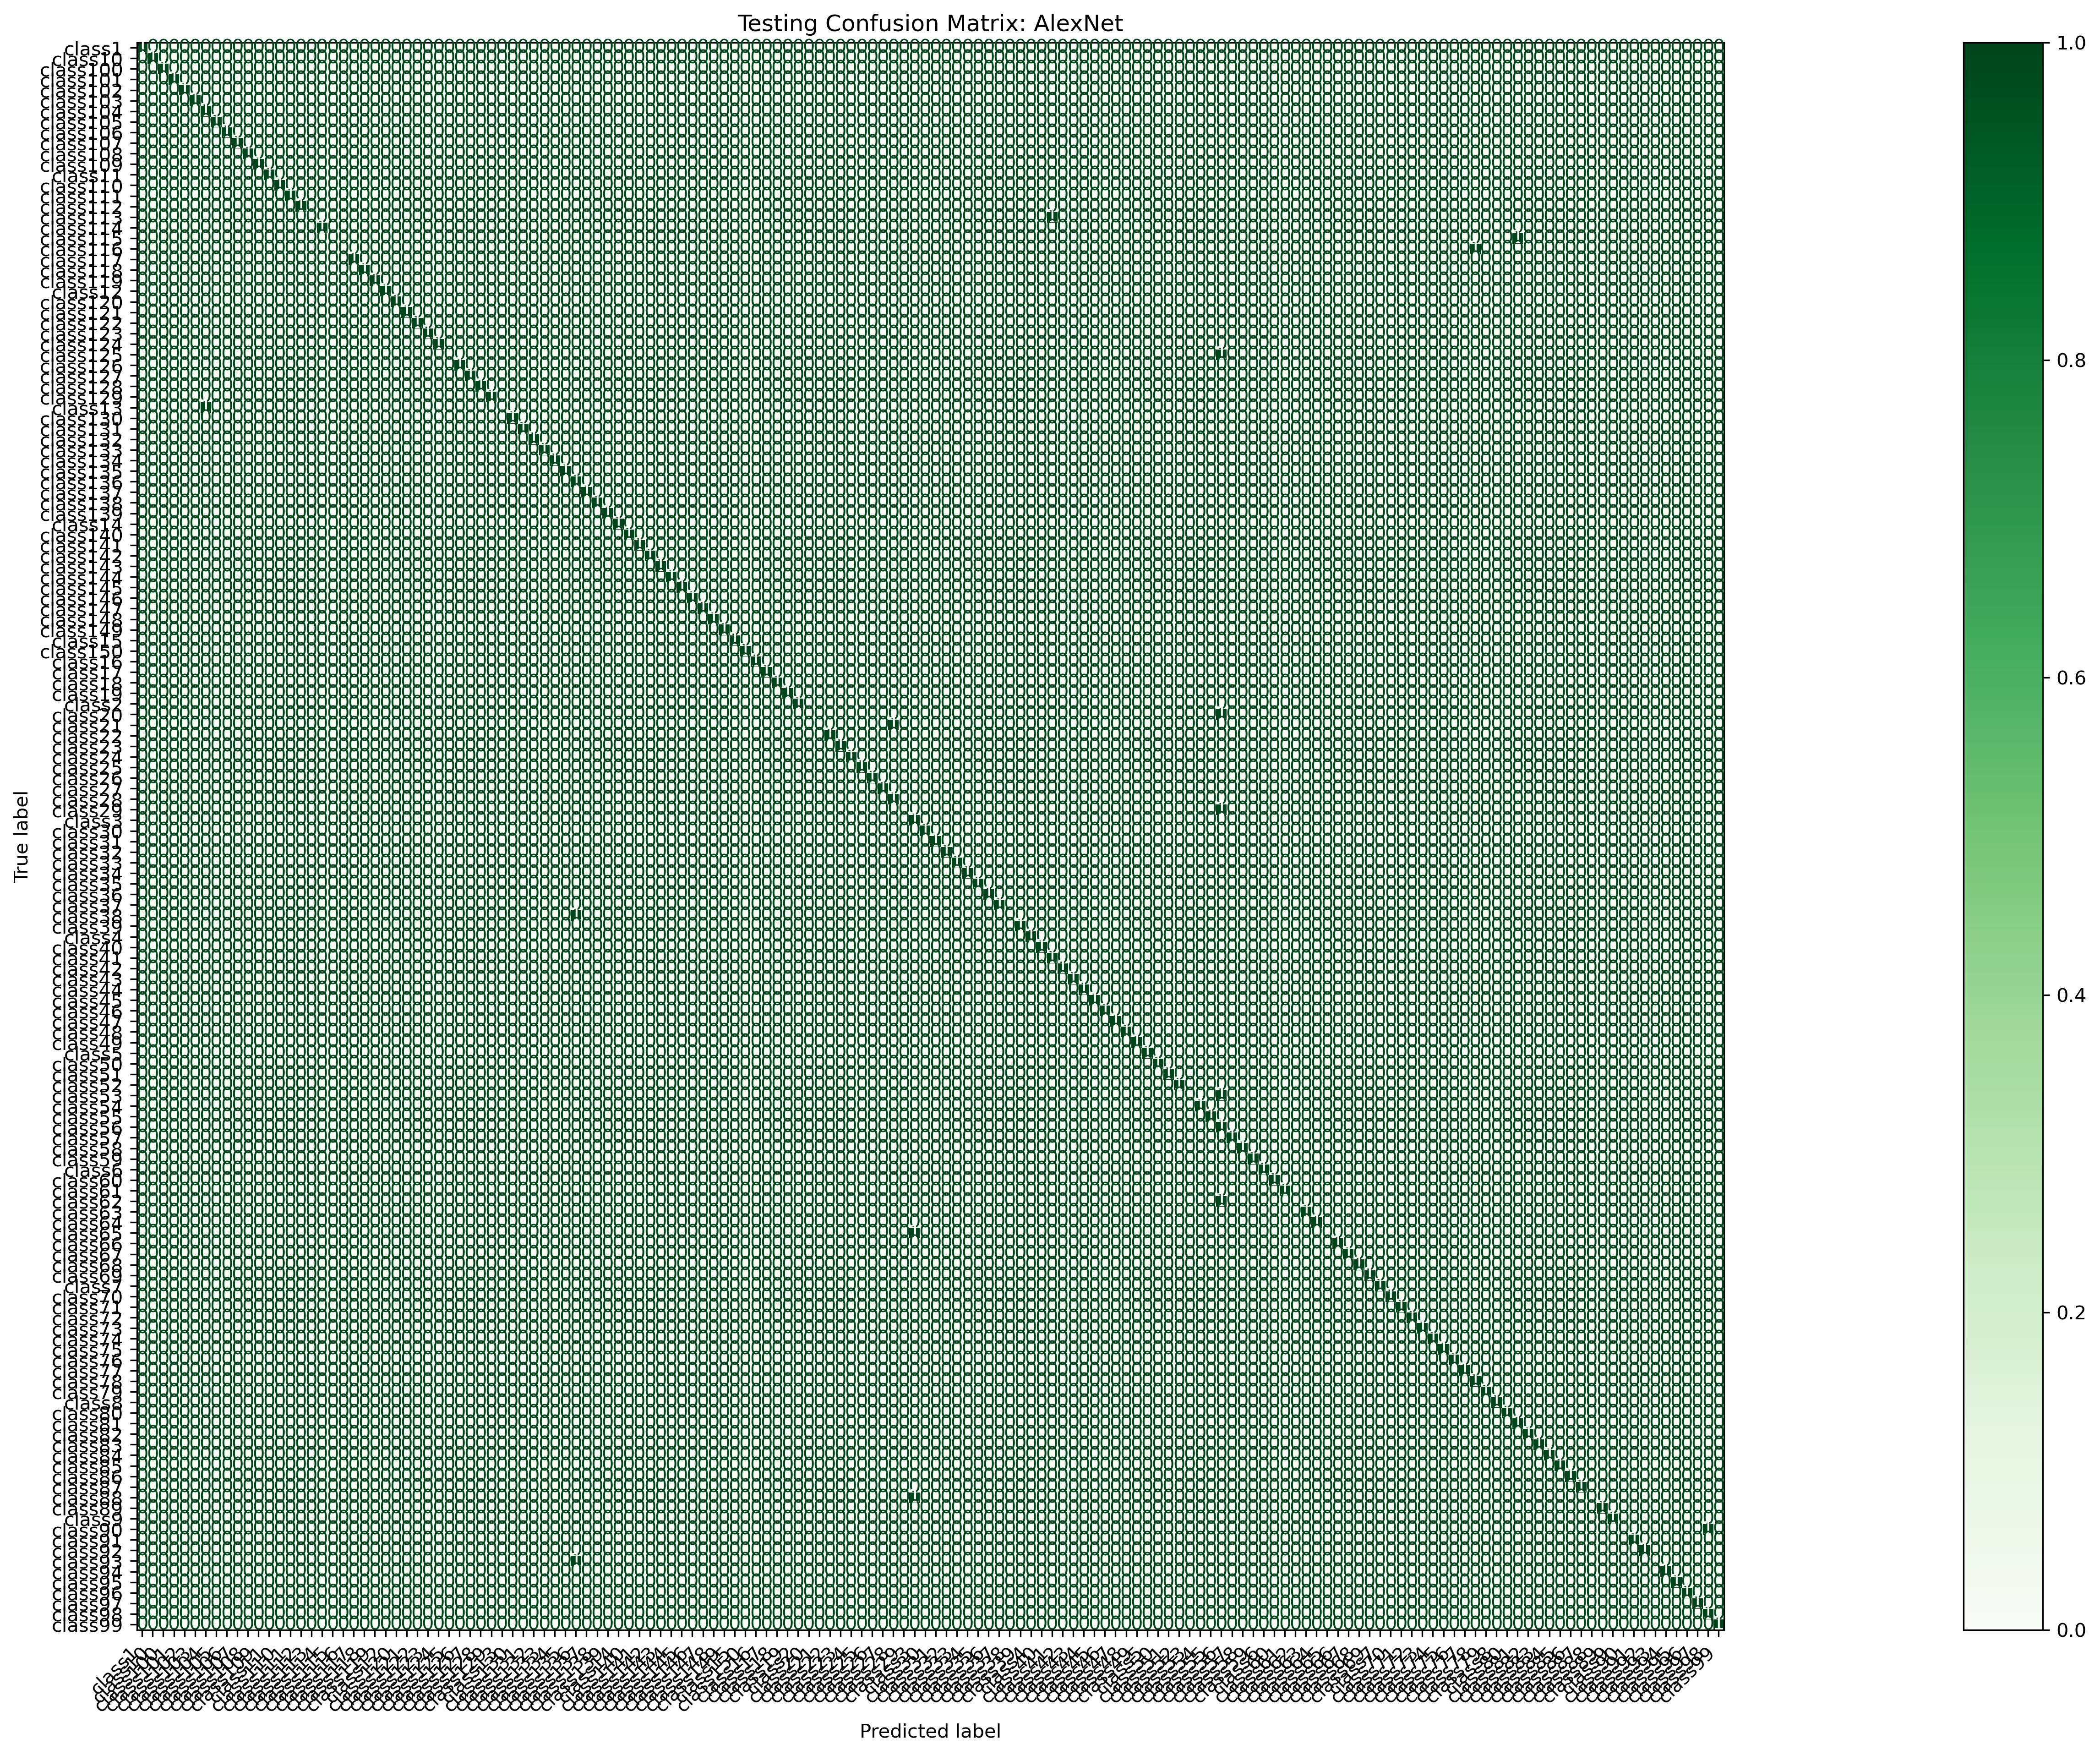

In [35]:
fig, ax = plt.subplots(figsize=(45, 15), dpi=300)
ConfusionMatrixDisplay(test_cm, display_labels=test_dataset.classes).plot(ax=ax, cmap=plt.cm.Greens)
ax.set_title('Testing Confusion Matrix: AlexNet')
ax.set_xticklabels(rotation=45, labels=test_dataset.classes, ha='right')
plt.show()